In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import time

from adversarial_ml import adversarial_attacks as attacks
from adversarial_ml import custom_model as models

# Load MNIST Dataset

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(60000,28, 28,1).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 28, 28, 1).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


# Build Models

In [3]:
class Hparams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [28, 28, 1]
        self.num_classes = 10
        self.num_conv_filters = [32, 64, 64]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        self.total_batch_size = 32
        self.adv_batch_size = 16
        

hparams = Hparams()

In [4]:
def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(
        shape=[28,28,1], dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    # Convolutional layer followed by 
    for i, num_filters in enumerate(hparams.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, hparams.kernel_size, activation='relu')(x)
        if i < len(hparams.num_conv_filters) - 1:
            # max pooling between convolutional layers
            x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
    x = tf.keras.layers.Flatten()(x)

    for num_units in hparams.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                                    adv_training_with=adv_training_with)

def get_fcc_model(adv_training_with=None, gaussian_noise=0.2):
    # Input shape 
    inputs = tf.keras.Input(
        shape=[28,28,1], dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    x = tf.keras.layers.Flatten()(x)

    for num_units in [64,32, 32]:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    
    return models.CustomModel(inputs=inputs, outputs=pred, 
                                    adv_training_with=adv_training_with)

# Fully Connected Model Without Adversarial Training

In [5]:
# Build Model
fcc_model = get_fcc_model()
fcc_model.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [6]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.Accuracy]
optimizer = tf.keras.optimizers.RMSprop()

# Compile Model
fcc_model.compile(optimizer=optimizer,
              loss=loss, metrics=["accuracy"])
# Train Model
fcc_model.fit(x_train, y_train,
          batch_size=32,
          epochs=2, validation_split=0.2)
# Evaluate Model
print("\n")
evaluation = fcc_model.evaluate(x_test, y_test, verbose=2)
# Test Adversarial Robustness
fcc_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/2
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4018 - accuracy: 0.8797 - val_loss: 0.1815 - val_accuracy: 0.9477
Epoch 2/2
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2031 - accuracy: 0.9380 - val_loss: 0.1506 - val_accuracy: 0.9542


313/313 - 0s - loss: 0.1385 - accuracy: 0.9576
Test adversarial robustness for model trainedtrained without adversarial examles
FGSM - eps: 0.30 - accuracy: 0.0
Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - accuracy: 0.0
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.0
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.35
One Step Least Likely (Step 1.1) - eps: 0.30 - accuracy: 0.05


# CNN Model Without Adversarial Training

In [7]:
cnn_model = get_cnn_model()
cnn_model.summary()

Model: "custom_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)       

In [8]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy]
optimizer = tf.keras.optimizers.RMSprop()

# Compile Model
cnn_model.compile(optimizer=optimizer,
              loss=loss, metrics=["accuracy"])
# Train Model 
cnn_model.fit(x_train, y_train,
          batch_size=32,
          epochs=2, validation_split=0.2)

# Evaluate Model
print("\n")
evaluation = cnn_model.evaluate(x_test,y_test, verbose=2)
# Test Adversarial Robustness
print("\n")
cnn_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/2
1500/1500 [==============================] - 20s 13ms/step - loss: 0.1873 - accuracy: 0.9407 - val_loss: 0.0517 - val_accuracy: 0.9846
Epoch 2/2
1500/1500 [==============================] - 19s 13ms/step - loss: 0.0597 - accuracy: 0.9817 - val_loss: 0.0628 - val_accuracy: 0.9827


313/313 - 1s - loss: 0.0454 - accuracy: 0.9852


Test adversarial robustness for model trainedtrained without adversarial examles
FGSM - eps: 0.30 - accuracy: 0.25
Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - accuracy: 0.34
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.02
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.7
One Step Least Likely (Step 1.1) - eps: 0.30 - accuracy: 0.57


# Adversarial Training (With CNN Model)

In [9]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy]
optimizer = tf.keras.optimizers.RMSprop()

# Adversarial Training With FGSM

In [10]:
# Set Adversarial Training Parameters
eps = 0.3
attack_kwargs = {"eps": eps}
adv_training_with = {"attack": attacks.Fgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

cnn_model_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_fgsm.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])
cnn_model_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_fgsm.test_adv_robustness(x_test[:100], y_test[:100])

Epoch 1/2
1500/1500 [==============================] - 25s 17ms/step - loss: 0.6851 - accuracy: 0.7680 - val_loss: 0.1213 - val_accuracy: 0.9630
Epoch 2/2
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2933 - accuracy: 0.9041 - val_loss: 0.0792 - val_accuracy: 0.9786


313/313 - 1s - loss: 0.0687 - accuracy: 0.9798


Test adversarial robustness for model trainedadversarially trained with FGSM - eps: 0.30
FGSM - eps: 0.30 - accuracy: 0.86
Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - accuracy: 0.9
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.38
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.95
One Step Least Likely (Step 1.1) - eps: 0.30 - accuracy: 0.9


# Adversarial Training With Random+FGSM

In [11]:
# Get adversarial training parameters
eps = 0.3
attack_kwargs = {"eps": eps, "alpha":1.25*eps}
adv_training_with = {"attack": attacks.RandomPlusFgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}
# Build model
cnn_model_random_plus_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_random_plus_fgsm.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])

#Train model
cnn_model_random_plus_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_random_plus_fgsm.test_adv_robustness(x_test[:100], y_test[:100])

Epoch 1/2
1500/1500 [==============================] - 26s 18ms/step - loss: 0.6427 - accuracy: 0.7831 - val_loss: 0.0743 - val_accuracy: 0.9793
Epoch 2/2
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3124 - accuracy: 0.8952 - val_loss: 0.0628 - val_accuracy: 0.9817


313/313 - 1s - loss: 0.0687 - accuracy: 0.9798


Test adversarial robustness for model trainedadversarially trained with Random Plus FGSM - eps: 0.30 - alpha: 0.3750
FGSM - eps: 0.30 - accuracy: 0.8
Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - accuracy: 0.89
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.59
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.96
One Step Least Likely (Step 1.1) - eps: 0.30 - accuracy: 0.92


# Adversarial Training With Basic Iterative Method

In [12]:
# Set adversarial training parameters
eps = 0.3
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter}
adv_training_with = {"attack": attacks.BasicIter,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_basic_iter = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_basic_iter.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])

# Train model
cnn_model_basic_iter.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_basic_iter.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_basic_iter.test_adv_robustness(x_test, y_test, eps=0.3)

Epoch 1/2
1500/1500 [==============================] - 182s 121ms/step - loss: 0.7988 - accuracy: 0.7253 - val_loss: 0.0969 - val_accuracy: 0.9727
Epoch 2/2
1500/1500 [==============================] - 184s 122ms/step - loss: 0.3999 - accuracy: 0.8624 - val_loss: 0.0640 - val_accuracy: 0.9832


313/313 - 1s - loss: 0.0623 - accuracy: 0.9836


Test adversarial robustness for model trainedadversarially trained with Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40
FGSM - eps: 0.30 - accuracy: 0.8548
Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - accuracy: 0.878
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.763
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.9625
One Step Least Likely (Step 1.1) - eps: 0.30 - accuracy: 0.9389


# Adversarial Attack Demo

In [13]:
def image_demo(model, attack, images, labels):
    """ Demo of adversarial attack on 20 images
    model: tf,keras.Model
    adv_attack: instance of AdversarialAttack
    images: tensor of shape (20, height, width, channels)
    labels: tensor of shape (20,)
    """
    assert images.shape[0] == 20
    fig, axs = plt.subplots(4, 11, figsize = (15,8))
    
    # Plot model predictions on clean images
    for i in range(4):
        for j in range(5):
            image = images[5*i+j]
            label = labels[5*i+j]
            ax = axs[i,j]
            ax.imshow(tf.squeeze(image), cmap="gray")
            ax.axis("off")
            
            prediction = model(tf.expand_dims(image, axis=0))
            prediction = tf.math.argmax(prediction, axis=1)
            prediction = tf.squeeze(prediction)           
            color = "green" if prediction.numpy() == label.numpy() else "red"
                    
            ax.set_title("Pred: " + str(prediction.numpy()),
                         color=color, fontsize=18)
    # Plot empty column 
    for i in range(4):
        axs[i,5].axis("off")
        
    # Plot model predictions on adversarial examples
    if attack.name in ["Iterative Least Likely (Iter 1.1)", 
                       "One Step Least Likely (Step 1.1)"]:
        attack_inputs = (images,)
    else:
        attack_inputs = (images, labels)

    adv_examples = attack(*attack_inputs)
    for i in range(4):
        for j in range(5):
            image = adv_examples[5*i+j]
            label = labels[5*i+j]
            ax = axs[i,6+j]
            ax.imshow(tf.squeeze(image),cmap="gray")
            ax.axis("off")
            
            prediction = model(tf.expand_dims(image,axis=0))
            prediction = tf.math.argmax(prediction, axis=1)
            prediction = tf.squeeze(prediction)
            color = "green" if prediction.numpy() ==label.numpy() else "red"
            
            ax.set_title("Pred: " + str(prediction.numpy()),
                         color=color, fontsize=18)
    
    plt.subplots_adjust(hspace=0.4)
    plt.figtext(0.16,0.93,"Model Prediction on Clean Images", fontsize=18)   
    plt.figtext(0.55,0.93,"Model Prediction on Adversarial Examples", fontsize=18)
    plt.figtext(0.1,1, adv_attack.specifics, fontsize=24, color="blue")

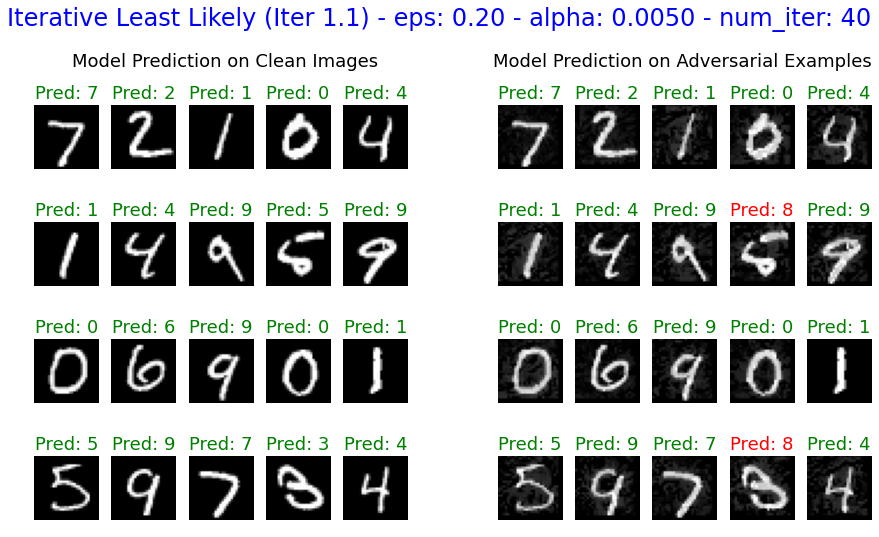

In [14]:
eps = 0.2
num_iter = 40
adv_attack = attacks.IterativeLeastLikely(model=cnn_model, 
                                          eps=tf.constant(eps,dtype=tf.float32),
                                          alpha=tf.constant(eps/num_iter,dtype=tf.float32),
                                          num_iter=tf.constant(num_iter,dtype=tf.int32))

image_demo(cnn_model, adv_attack, x_test[:20], y_test[:20])

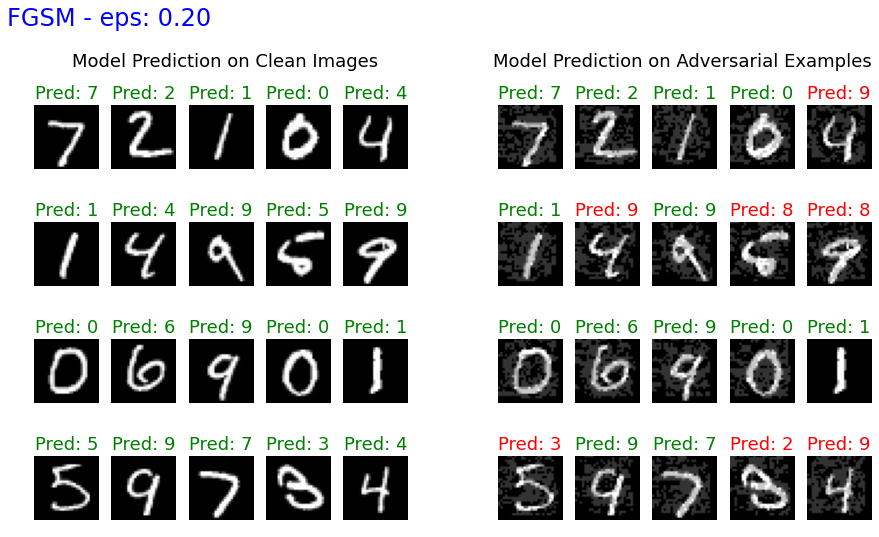

In [15]:
eps = 0.2
num_iter = 40
adv_attack = attacks.Fgsm(model=cnn_model,
                          eps=tf.constant(eps,dtype=tf.float32))


image_demo(cnn_model, adv_attack, x_test[:20], y_test[:20])

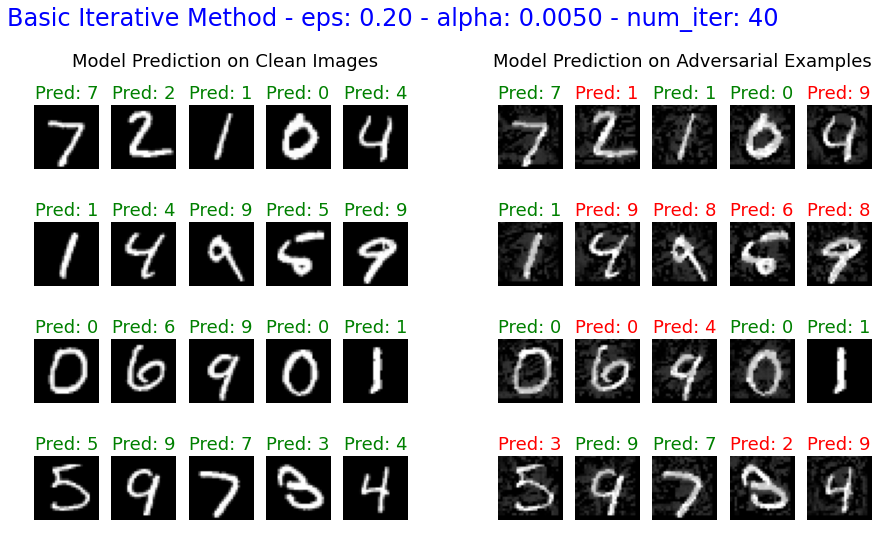

In [16]:
eps = 0.2
num_iter = 40
adv_attack = attacks.BasicIter(model=cnn_model, 
                               eps=tf.constant(eps,dtype=tf.float32),
                               alpha=tf.constant(eps/num_iter,dtype=tf.float32),
                               num_iter=tf.constant(num_iter,dtype=tf.int32))

image_demo(cnn_model, adv_attack, x_test[:20], y_test[:20])

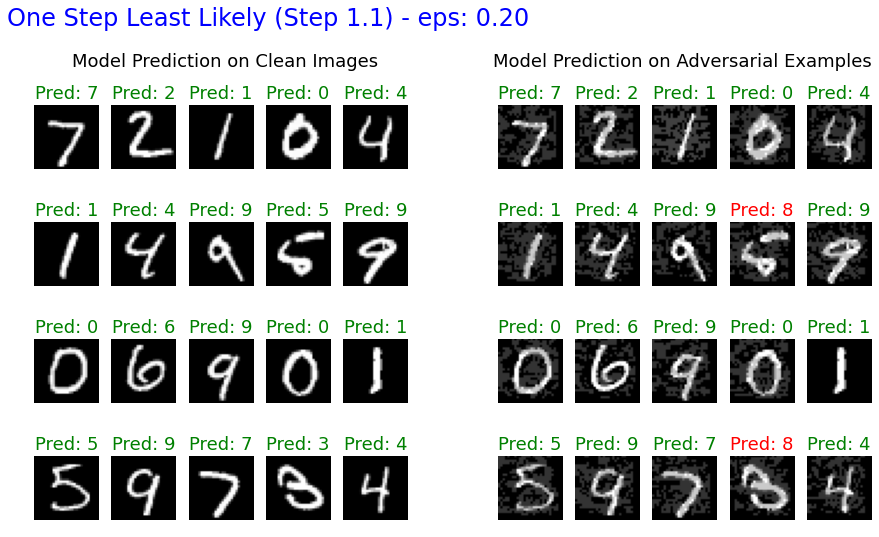

In [17]:
eps = 0.2
num_iter = 40
adv_attack = attacks.OneStepLeastLikely(model=cnn_model, 
                                        eps=tf.constant(eps,dtype=tf.float32))

image_demo(cnn_model, adv_attack, x_test[:20], y_test[:20])

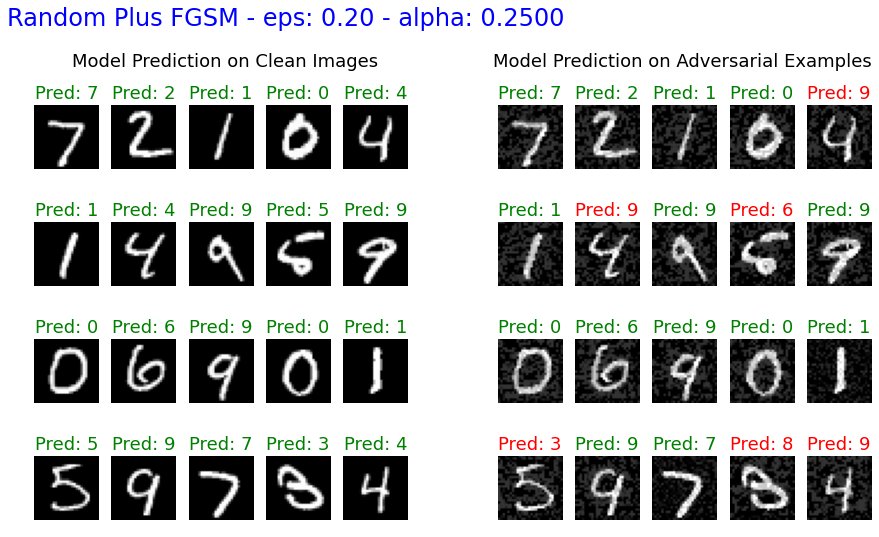

In [18]:
eps = 0.2
alpha = 1.25*eps
num_iter = 40
adv_attack = attacks.RandomPlusFgsm(model=cnn_model,
                                    eps=tf.constant(eps,dtype=tf.float32),
                                    alpha=tf.constant(alpha, dtype=tf.float32))


image_demo(cnn_model, adv_attack, x_test[:20], y_test[:20])